<a href="https://colab.research.google.com/github/josephxlp/PyTorch100Days/blob/main/W2DAY11_Handwritten_Character_Recognition_(EMNIST).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

W2D11: Handwritten Character Recognition (EMNIST)

Description:
- the EMNIST dataset (an extended version of MNIST with letters and digits) to train a character recognizer using a convolutional neural network.

Goal:
- Classify handwritten letters and digits from the EMNIST Balanced dataset using a CNN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [4]:
transform = transforms.Compose([
    transforms.RandomRotation((-90, 90)),
    transforms.ToTensor()])

In [5]:
train_ds = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_ds = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)

100%|██████████| 562M/562M [00:02<00:00, 244MB/s]


In [6]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=500, shuffle=False)

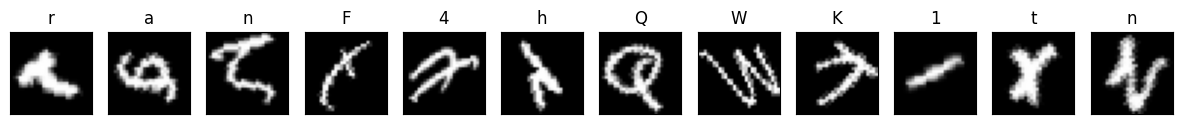

In [9]:
fig = plt.figure(figsize=(15, 15))
for i in range(12):
    ax = fig.add_subplot(1, 12, i+1, xticks=[], yticks=[])
    # EMNIST images are 28x28, no need to squeeze or transpose
    ax.imshow(train_ds[i][0].squeeze(), cmap='gray')
    ax.set_title(f'{train_ds.classes[train_ds[i][1]]}')
plt.show()

In [10]:

# Assume train_ds and train_dl are already defined from previous cells

class EMISTClassifier(nn.Module):
    def __init__(self):
        super(EMISTClassifier, self).__init__()
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Define the second convolutional layer with input channels matching the output of the first
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Assuming the input size after two conv/pool layers is 7x7 based on the linear layer size
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, len(train_ds.classes))

    def forward(self, x):
        # Apply the first convolutional layer, activation, and pooling
        x = self.pool1(F.relu(self.conv1(x)))
        # Apply the second convolutional layer, activation, and pooling
        x = self.pool1(F.relu(self.conv2(x)))
        # Flatten the tensor for the linear layers
        x = x.view(-1, 64 * 7 * 7)
        # Apply the first linear layer and activation
        x = F.relu(self.fc1(x))
        # Apply the second linear layer
        x = self.fc2(x)
        return x # Added return statement

# Rest of the code for training loop remains the same
model = EMISTClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(device)

EMISTClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=47, bias=True)
)

In [11]:
for epoch in range(7):
    model.train()
    running_loss = 0.0
    pbar = tqdm(enumerate(train_dl), total=len(train_dl))
    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_description(f"Epoch {epoch+1} - Loss: {running_loss/(i+1):.4f}")

print('--- training finished ---')

Epoch 7 - Loss: 0.7368: 100%|██████████| 1763/1763 [00:29<00:00, 60.64it/s]

--- training finished ---


In [13]:
# Evaluation
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dl:
        # Move images and labels to the same device as the model
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 76.33%


In [ ]:
# better code and add another model to improve performance